In [82]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

In [56]:
df = pd.read_csv('datasets/weather.csv')

In [44]:
df

,station_id,city_name,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa
0,13588,Skopje,2021-01-01,Winter,5.1,0.5,13.2,0.0,330.0,5.9,1021.2
1,13588,Skopje,2021-01-02,Winter,3.0,-2.6,11.2,0.0,330.0,5.9,1021.2
2,13588,Skopje,2021-01-03,Winter,6.8,3.5,12.5,1.3,339.0,8.0,1017.8
3,13588,Skopje,2021-01-04,Winter,6.6,6.1,7.2,3.6,298.0,5.3,1011.3
4,13588,Skopje,2021-01-05,Winter,4.3,2.3,6.7,4.6,11.0,5.1,1014.5
...,...,...,...,...,...,...,...,...,...,...,...
938,13588,Skopje,2023-07-28,Summer,22.8,12.3,32.7,0.0,2.0,6.8,1014.6
939,13588,Skopje,2023-07-29,Summer,26.3,16.3,35.4,0.0,261.0,6.2,1011.7
940,13588,Skopje,2023-07-30,Summer,28.2,19.5,36.4,0.0,317.0,8.0,1009.8
941,13588,Skopje,2023-07-31,Summer,25.8,20.9,32.1,0.0,307.0,12.3,1010.9


In [9]:
# filtered_df = df[df['station_id'] == 13588]
# filtered_df

In [57]:
df.drop(columns=['station_id', 'city_name'], inplace=True)

In [58]:
df['date'] = pd.to_datetime(df['date'])
df.set_index(keys='date', inplace=True)
df.sort_index(inplace=True)

In [47]:
df

,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa
date,,,,,,,,
2021-01-01,Winter,5.1,0.5,13.2,0.0,330.0,5.9,1021.2
2021-01-02,Winter,3.0,-2.6,11.2,0.0,330.0,5.9,1021.2
2021-01-03,Winter,6.8,3.5,12.5,1.3,339.0,8.0,1017.8
2021-01-04,Winter,6.6,6.1,7.2,3.6,298.0,5.3,1011.3
2021-01-05,Winter,4.3,2.3,6.7,4.6,11.0,5.1,1014.5
...,...,...,...,...,...,...,...,...
2023-07-28,Summer,22.8,12.3,32.7,0.0,2.0,6.8,1014.6
2023-07-29,Summer,26.3,16.3,35.4,0.0,261.0,6.2,1011.7
2023-07-30,Summer,28.2,19.5,36.4,0.0,317.0,8.0,1009.8


In [23]:
df.isnull().sum()

season                    0
avg_temp_c                0
min_temp_c                0
max_temp_c                0
precipitation_mm          0
avg_wind_dir_deg          0
avg_wind_speed_kmh        0
avg_sea_level_pres_hpa    0
dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 943 entries, 2021-01-01 to 2023-08-01
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   season                  943 non-null    object 
 1   avg_temp_c              943 non-null    float64
 2   min_temp_c              943 non-null    float64
 3   max_temp_c              943 non-null    float64
 4   precipitation_mm        943 non-null    float64
 5   avg_wind_dir_deg        943 non-null    float64
 6   avg_wind_speed_kmh      943 non-null    float64
 7   avg_sea_level_pres_hpa  943 non-null    float64
dtypes: float64(7), object(1)
memory usage: 66.3+ KB


In [59]:
encoder = LabelEncoder()

df['season'] = encoder.fit_transform(df['season'])

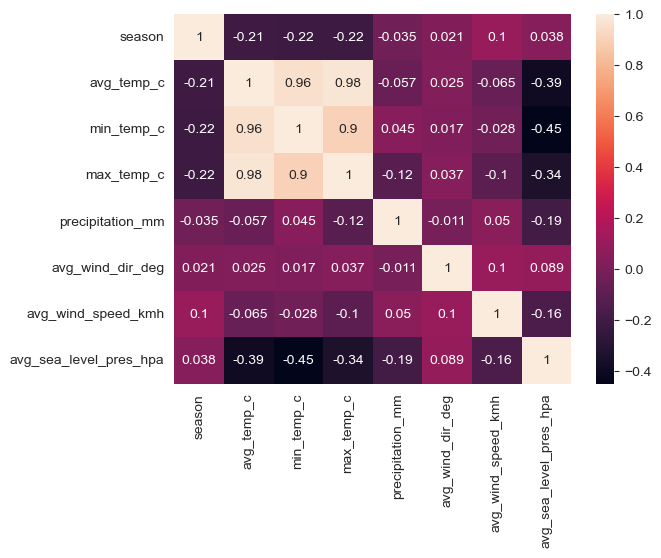

In [60]:
sns.heatmap(df.corr(), annot=True)
plt.show()

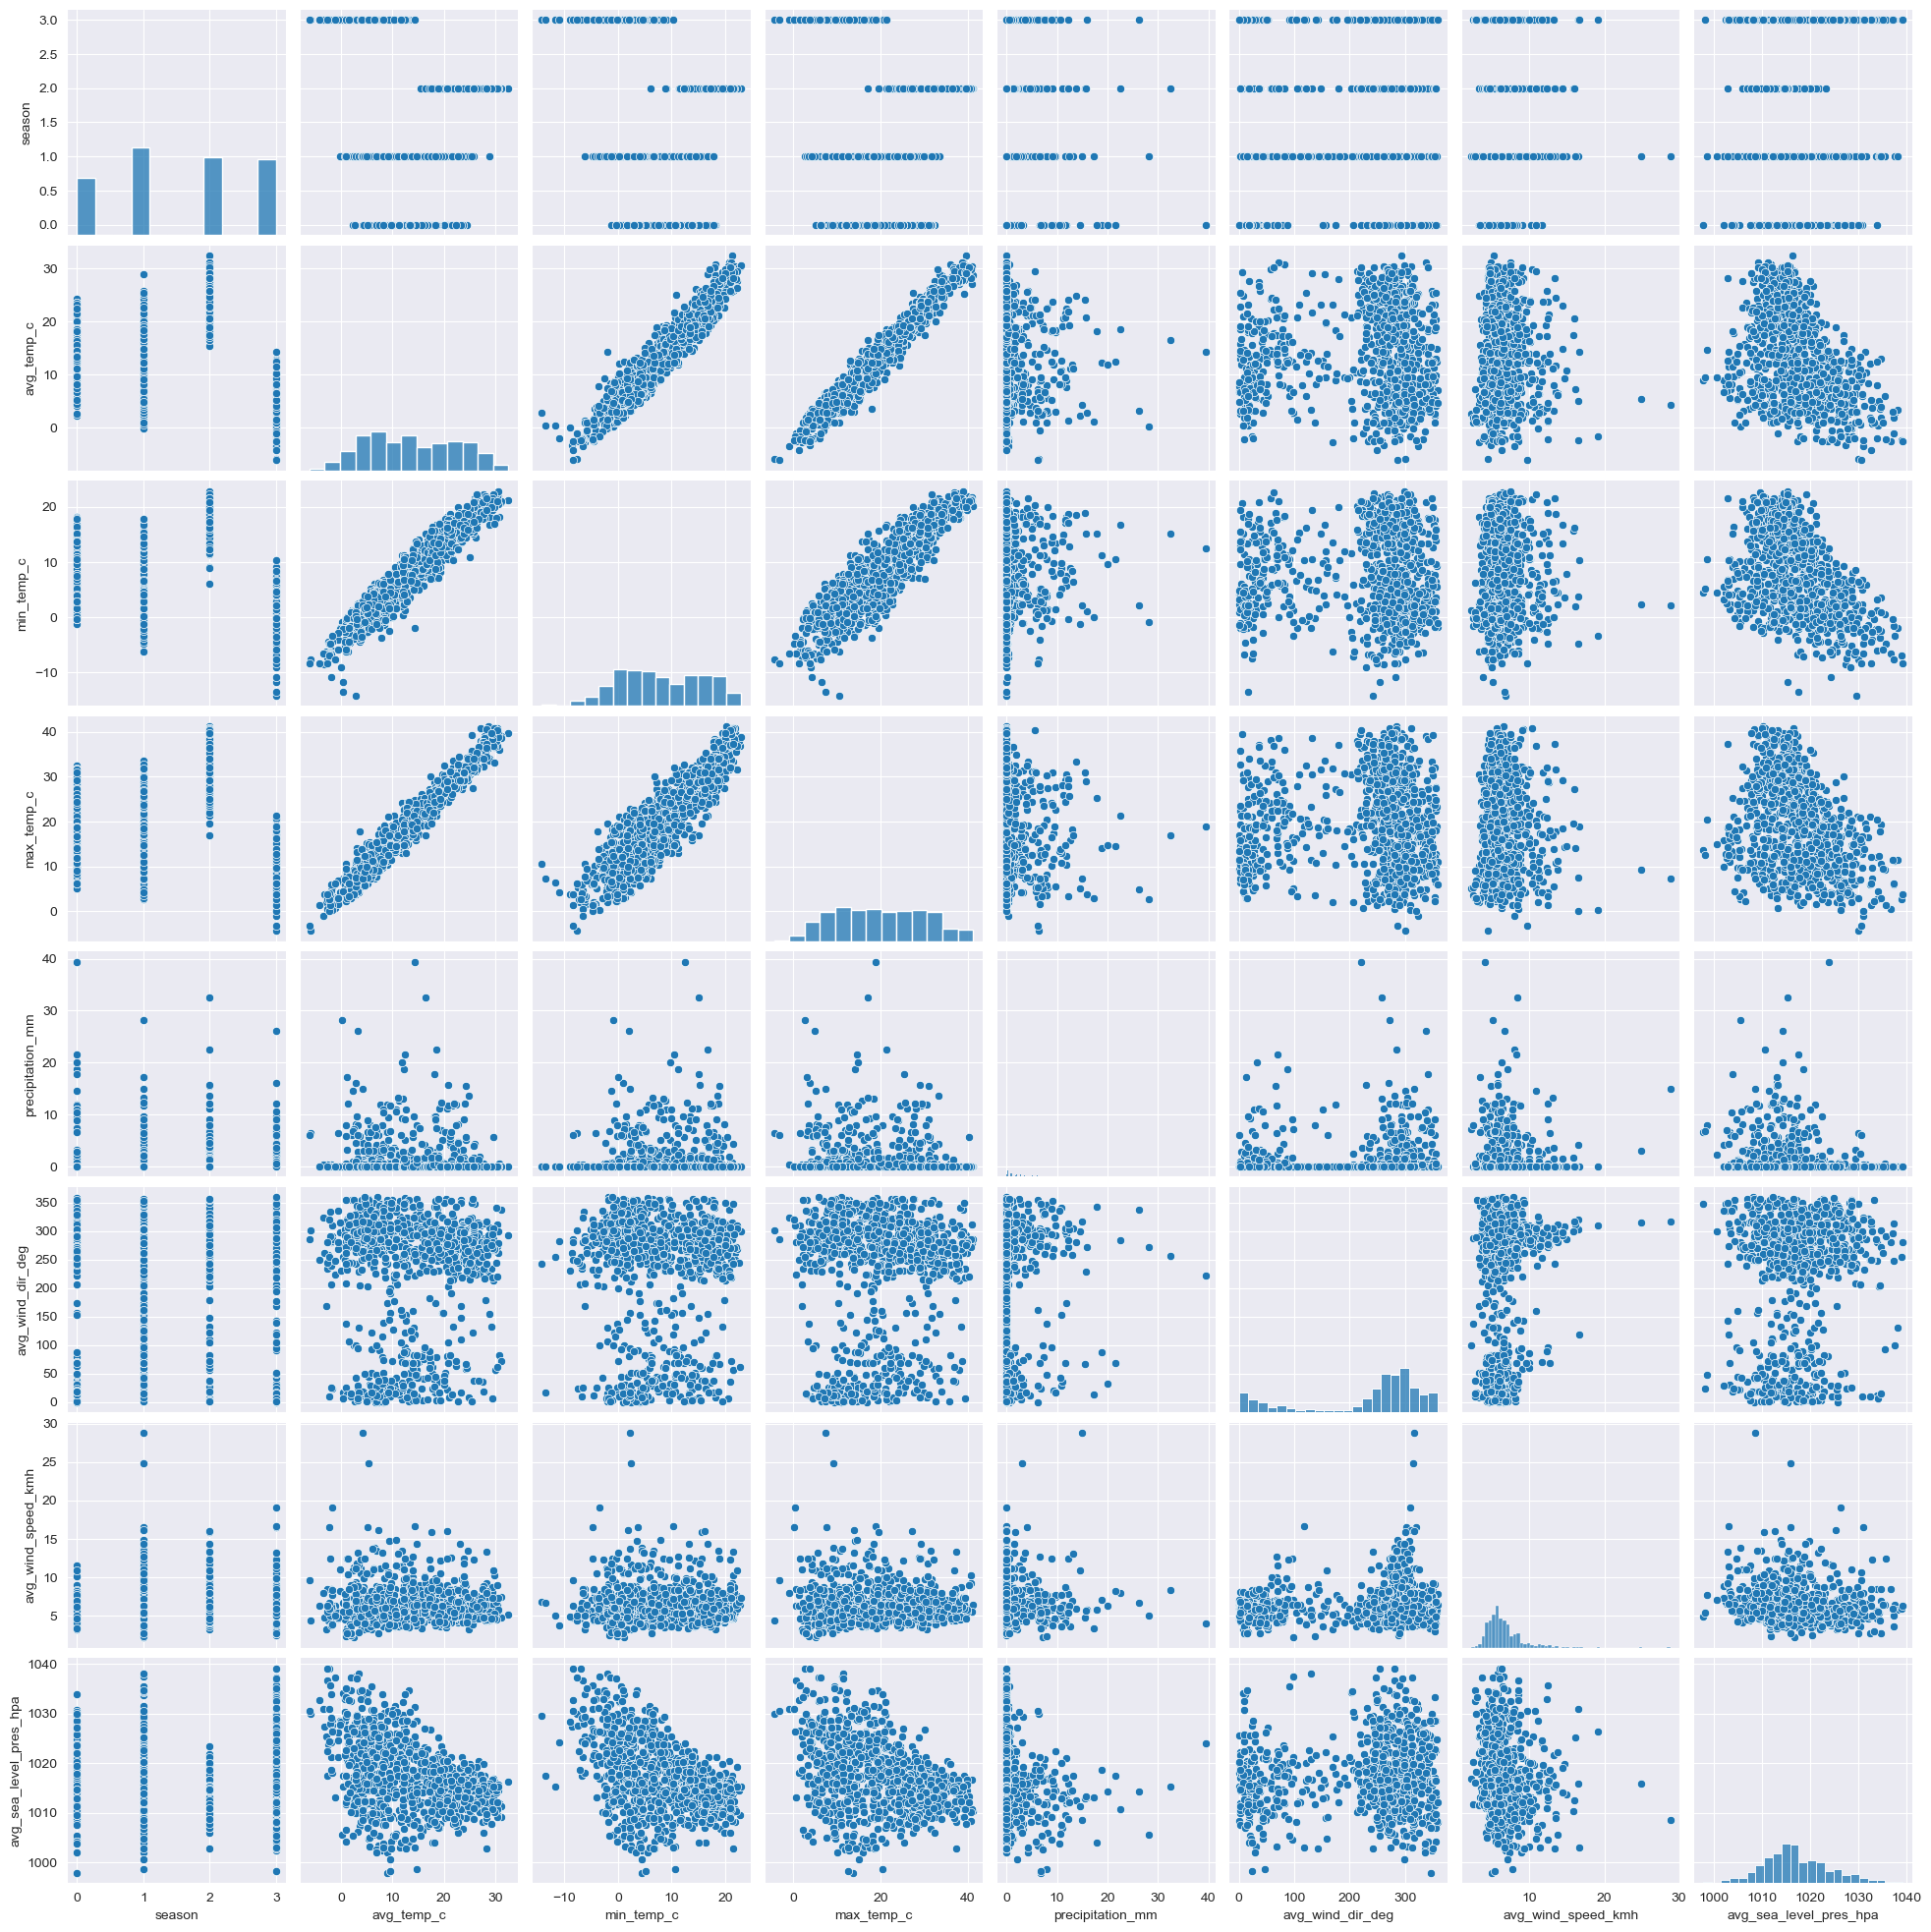

In [33]:
sns.pairplot(df)

In [61]:
# drop correlated features
features = ['precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'avg_temp_c']
target = 'avg_sea_level_pres_hpa'

In [62]:
for feature in features: 
    df[feature] = df[feature].interpolate(method='linear')

In [63]:
df_copy = df.drop(columns=['season', 'min_temp_c', 'max_temp_c'])

In [64]:
df_copy

,avg_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa
date,,,,,
2021-01-01,5.1,0.0,330.0,5.9,1021.2
2021-01-02,3.0,0.0,330.0,5.9,1021.2
2021-01-03,6.8,1.3,339.0,8.0,1017.8
2021-01-04,6.6,3.6,298.0,5.3,1011.3
2021-01-05,4.3,4.6,11.0,5.1,1014.5
...,...,...,...,...,...
2023-07-28,22.8,0.0,2.0,6.8,1014.6
2023-07-29,26.3,0.0,261.0,6.2,1011.7
2023-07-30,28.2,0.0,317.0,8.0,1009.8


In [65]:
for lag in range(3, 0, -1):
    for feature in features + [target]:
        df_copy[f'{feature}_lag_{lag}'] = df_copy[feature].shift(lag)

In [66]:
df_copy.drop(columns=features, inplace=True)

In [67]:
df_copy

,avg_sea_level_pres_hpa,precipitation_mm_lag_3,avg_wind_dir_deg_lag_3,avg_wind_speed_kmh_lag_3,avg_temp_c_lag_3,avg_sea_level_pres_hpa_lag_3,precipitation_mm_lag_2,avg_wind_dir_deg_lag_2,avg_wind_speed_kmh_lag_2,avg_temp_c_lag_2,avg_sea_level_pres_hpa_lag_2,precipitation_mm_lag_1,avg_wind_dir_deg_lag_1,avg_wind_speed_kmh_lag_1,avg_temp_c_lag_1,avg_sea_level_pres_hpa_lag_1
date,,,,,,,,,,,,,,,,
2021-01-01,1021.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,1021.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,330.0,5.9,5.1,1021.2
2021-01-03,1017.8,NaN,NaN,NaN,NaN,NaN,0.0,330.0,5.9,5.1,1021.2,0.0,330.0,5.9,3.0,1021.2
2021-01-04,1011.3,0.0,330.0,5.9,5.1,1021.2,0.0,330.0,5.9,3.0,1021.2,1.3,339.0,8.0,6.8,1017.8
2021-01-05,1014.5,0.0,330.0,5.9,3.0,1021.2,1.3,339.0,8.0,6.8,1017.8,3.6,298.0,5.3,6.6,1011.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-28,1014.6,0.0,275.0,4.7,29.2,1007.7,0.0,242.0,13.4,28.2,1002.9,0.0,316.0,16.0,20.7,1012.6
2023-07-29,1011.7,0.0,242.0,13.4,28.2,1002.9,0.0,316.0,16.0,20.7,1012.6,0.0,2.0,6.8,22.8,1014.6
2023-07-30,1009.8,0.0,316.0,16.0,20.7,1012.6,0.0,2.0,6.8,22.8,1014.6,0.0,261.0,6.2,26.3,1011.7


In [69]:
df_copy.isnull().sum()

avg_sea_level_pres_hpa          0
precipitation_mm_lag_3          3
avg_wind_dir_deg_lag_3          3
avg_wind_speed_kmh_lag_3        3
avg_temp_c_lag_3                3
avg_sea_level_pres_hpa_lag_3    3
precipitation_mm_lag_2          2
avg_wind_dir_deg_lag_2          2
avg_wind_speed_kmh_lag_2        2
avg_temp_c_lag_2                2
avg_sea_level_pres_hpa_lag_2    2
precipitation_mm_lag_1          1
avg_wind_dir_deg_lag_1          1
avg_wind_speed_kmh_lag_1        1
avg_temp_c_lag_1                1
avg_sea_level_pres_hpa_lag_1    1
dtype: int64

In [72]:
df_copy.dropna(axis=0, inplace=True)

In [73]:
df_copy

,avg_sea_level_pres_hpa,precipitation_mm_lag_3,avg_wind_dir_deg_lag_3,avg_wind_speed_kmh_lag_3,avg_temp_c_lag_3,avg_sea_level_pres_hpa_lag_3,precipitation_mm_lag_2,avg_wind_dir_deg_lag_2,avg_wind_speed_kmh_lag_2,avg_temp_c_lag_2,avg_sea_level_pres_hpa_lag_2,precipitation_mm_lag_1,avg_wind_dir_deg_lag_1,avg_wind_speed_kmh_lag_1,avg_temp_c_lag_1,avg_sea_level_pres_hpa_lag_1
date,,,,,,,,,,,,,,,,
2021-01-04,1011.3,0.0,330.0,5.9,5.1,1021.2,0.0,330.0,5.9,3.0,1021.2,1.3,339.0,8.0,6.8,1017.8
2021-01-05,1014.5,0.0,330.0,5.9,3.0,1021.2,1.3,339.0,8.0,6.8,1017.8,3.6,298.0,5.3,6.6,1011.3
2021-01-06,1017.2,1.3,339.0,8.0,6.8,1017.8,3.6,298.0,5.3,6.6,1011.3,4.6,11.0,5.1,4.3,1014.5
2021-01-07,1015.2,3.6,298.0,5.3,6.6,1011.3,4.6,11.0,5.1,4.3,1014.5,0.0,18.0,6.7,6.2,1017.2
2021-01-08,1009.7,4.6,11.0,5.1,4.3,1014.5,0.0,18.0,6.7,6.2,1017.2,0.5,0.0,4.5,7.3,1015.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-28,1014.6,0.0,275.0,4.7,29.2,1007.7,0.0,242.0,13.4,28.2,1002.9,0.0,316.0,16.0,20.7,1012.6
2023-07-29,1011.7,0.0,242.0,13.4,28.2,1002.9,0.0,316.0,16.0,20.7,1012.6,0.0,2.0,6.8,22.8,1014.6
2023-07-30,1009.8,0.0,316.0,16.0,20.7,1012.6,0.0,2.0,6.8,22.8,1014.6,0.0,261.0,6.2,26.3,1011.7


In [79]:
x = df_copy.drop(columns=target)
y = df_copy[target]

In [80]:
x

,precipitation_mm_lag_3,avg_wind_dir_deg_lag_3,avg_wind_speed_kmh_lag_3,avg_temp_c_lag_3,avg_sea_level_pres_hpa_lag_3,precipitation_mm_lag_2,avg_wind_dir_deg_lag_2,avg_wind_speed_kmh_lag_2,avg_temp_c_lag_2,avg_sea_level_pres_hpa_lag_2,precipitation_mm_lag_1,avg_wind_dir_deg_lag_1,avg_wind_speed_kmh_lag_1,avg_temp_c_lag_1,avg_sea_level_pres_hpa_lag_1
date,,,,,,,,,,,,,,,
2021-01-04,0.0,330.0,5.9,5.1,1021.2,0.0,330.0,5.9,3.0,1021.2,1.3,339.0,8.0,6.8,1017.8
2021-01-05,0.0,330.0,5.9,3.0,1021.2,1.3,339.0,8.0,6.8,1017.8,3.6,298.0,5.3,6.6,1011.3
2021-01-06,1.3,339.0,8.0,6.8,1017.8,3.6,298.0,5.3,6.6,1011.3,4.6,11.0,5.1,4.3,1014.5
2021-01-07,3.6,298.0,5.3,6.6,1011.3,4.6,11.0,5.1,4.3,1014.5,0.0,18.0,6.7,6.2,1017.2
2021-01-08,4.6,11.0,5.1,4.3,1014.5,0.0,18.0,6.7,6.2,1017.2,0.5,0.0,4.5,7.3,1015.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-28,0.0,275.0,4.7,29.2,1007.7,0.0,242.0,13.4,28.2,1002.9,0.0,316.0,16.0,20.7,1012.6
2023-07-29,0.0,242.0,13.4,28.2,1002.9,0.0,316.0,16.0,20.7,1012.6,0.0,2.0,6.8,22.8,1014.6
2023-07-30,0.0,316.0,16.0,20.7,1012.6,0.0,2.0,6.8,22.8,1014.6,0.0,261.0,6.2,26.3,1011.7


In [81]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

In [83]:
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [84]:
y_train = scaler.fit_transform(y_train.values.reshape(-1,1))

In [87]:
rf = RandomForestRegressor(n_estimators=150)

rf.fit(x_train, y_train)

/Users/davidhristov/miniconda3/envs/myenvconda2/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(n_estimators=150)

In [88]:
y_pred = rf.predict(x_test)

In [93]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))

In [94]:
# Write your code here. Add as many boxes as you need.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rfr_mse = mean_squared_error(y_test, y_pred)
rfr_mae = mean_absolute_error(y_test, y_pred)
rfr_r2 = r2_score(y_test, y_pred)
print(f'Random Forest\n')
print(f'MSE: {rfr_mse}')
print(f'MAE: {rfr_mae}')
print(f'R2 : {rfr_r2}')

Random Forest

MSE: 12.539147712765898
MAE: 2.664460992907794
R2 : 0.7155940371401737


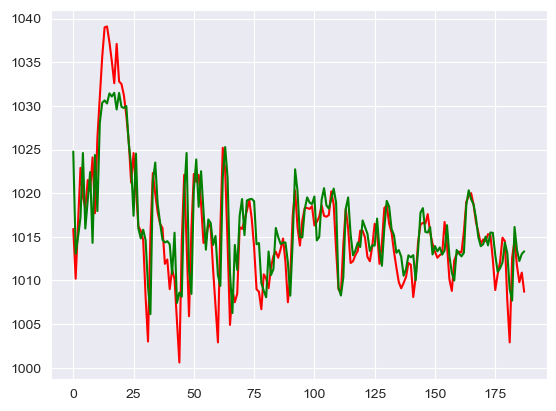

In [96]:
plt.plot(y_test.values, label='Actual', color='red')
plt.plot(y_pred, label='RF Prediction', color='green')
plt.show()

In [97]:
help(XGBRegressor)

Help on class XGBRegressor in module xgboost.sklearn:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  XGBRegressor(*, objective: Union[str, xgboost.sklearn._SklObjWProto, Callable[[Any, Any], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror', **kwargs: Any) -> None
 |  
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  See :doc:`/python/sklearn_estimator` for more information.
 |  
 |  Parameters
 |  ----------
 |  
 |      n_estimators : typing.Optional[int]
 |          Number of gradient boosted trees.  Equivalent to number of boosting
 |          rounds.
 |  
 |      max_depth :  typing.Optional[int]
 |  
 |          Maximum tree depth for base learners.
 |  
 |      max_leaves : typing.Optional[int]
 |  
 |          Maximum number of leaves; 0 indicates no limit.
 |  
 |      max_bin : typing.Optional[int]
 |  
 |          If using histogram-based algorithm, maximum number of bins per feature
 |  
 |      grow_policy : typing.O

In [98]:
xgb_model = XGBRegressor(n_estimators=150, max_depth=5, learning_rate = 0.01)

xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [99]:
y_pred_xgb = xgb_model.predict(x_test)

In [100]:
# Write your code here. Add as many boxes as you need.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rfr_mse = mean_squared_error(y_test, y_pred)
rfr_mae = mean_absolute_error(y_test, y_pred)
rfr_r2 = r2_score(y_test, y_pred)
print(f'Random Forest\n')
print(f'MSE: {rfr_mse}')
print(f'MAE: {rfr_mae}')
print(f'R2 : {rfr_r2}')

Random Forest

MSE: 12.539147712765898
MAE: 2.664460992907794
R2 : 0.7155940371401737


# BONUS TASK 

In [101]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

# Fine-tuning the Random Forest Hyperparameter

Experiment with various values for max_depth and evaluate the model's performance using cross-validation.

In [105]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {
    'max_depth' : [5,10,15,20],
    'n_estimators' : [100,150,200],
    'min_samples_split' : [2,4,6]
}

cv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid,cv=cv,scoring='neg_mean_squared_error')

grid_search.fit(x_train, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_squared_error')

In [106]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

In [108]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Best max_depth: {grid_search.best_params_['max_depth']}")
print(f"Mean Squared Error: {mse}")
print(f'Mean Absolute Error: {mae}')
print(f'R2 : {r2}')

Best max_depth: 10
Mean Squared Error: 4.4974996095743505
Mean Absolute Error: 1.5901774656120136
R2 : 0.5813878914825203


In [109]:
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 200}
RandomForestRegressor(max_depth=10, min_samples_split=6, n_estimators=200)
